In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import zipfile
import tqdm
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
root = './'
root_temp = './'

In [ ]:
#Unzips files
with zipfile.ZipFile(os.path.join('./train.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(root_temp))
with zipfile.ZipFile(os.path.join('./test1.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(root_temp))

In [ ]:
train_images = [fname 
                for fname in os.listdir(os.path.join(root_temp,'train'))]
test_images = [fname 
               for fname in os.listdir(os.path.join(root_temp,'test1'))]

In [ ]:
print('total number in training set ', len(train_images))
print('total number in test set ', len(test_images))

total number in training set  25000
total number in test set  12500


In [ ]:
pd.DataFrame(train_images).head()

,0
0,dog.2366.jpg
1,cat.3946.jpg
2,dog.9062.jpg
3,dog.12477.jpg
4,dog.9040.jpg


In [ ]:
pd.DataFrame(test_images).head()

,0
0,9091.jpg
1,9092.jpg
2,3334.jpg
3,7739.jpg
4,1379.jpg


In [ ]:
train_cats = []
train_dogs = []
for image in train_images:
    if 'cat' in image:
        train_cats.append(image)
    else: train_dogs.append(image)

In [ ]:
print('total number of cats in training set ', len(train_cats))
print('total number of dogs in training set ', len(train_dogs))
print('total number of images in test set ', len(test_images))

total number of cats in training set  12500
total number of dogs in training set  12500
total number of images in test set  12500


In [ ]:
try:
    os.mkdir(os.path.join(root_temp,'train','cat'))
    os.mkdir(os.path.join(root_temp,'train','dog'))
except OSError:
    pass

In [ ]:
import shutil 

for image in train_cats:
    shutil.move(os.path.join(root_temp,'train',image),os.path.join(root_temp,'train','cat',image))
    
for image in train_dogs:
    shutil.move(os.path.join(root_temp,'train',image),os.path.join(root_temp,'train','dog',image))

train_root = os.path.join(root_temp,'train') 
train_cats = os.path.join(train_root,'cat')
train_dogs = os.path.join(train_root,'dog')

val_root = os.path.join(root_temp,'val')
val_cat = os.path.join(val_root,'cat')
val_dog = os.path.join(val_root,'dog')

root_test = os.path.join(root_temp,'test1')

try:
    os.mkdir(val_root)
    os.mkdir(val_cat)
    os.mkdir(val_dog)
except OSError:
    pass

In [ ]:
from tqdm import tqdm

for index in tqdm(range(1500)):
    #moves first 1500 images from /kaggle/working/train/cat to /kaggle/working/val/cat 
    shutil.move(os.path.join(root_temp,'train','cat',os.listdir(os.path.join(root_temp,'train','cat'))[index]),val_cat)
    shutil.move(os.path.join(root_temp,'train','dog',os.listdir(os.path.join(root_temp,'train','dog'))[index]),val_dog)

100%|██████████| 1500/1500 [00:18<00:00, 82.91it/s]


In [ ]:
#confirms the number of cats and dogs in folders
print('total number of cats in training folder ', len(os.listdir(train_cats)))
print('total number of dogs in training folder ', len(os.listdir(train_dogs)))
print('total number of cats in validation folder ', len(os.listdir(val_cat)))
print('total number of dogs in validation folder ', len(os.listdir(val_dog)))
print('total number of iamges in testing folder ', len(os.listdir(root_test)))

total number of cats in training folder  11000
total number of dogs in training folder  11000
total number of cats in validation folder  1500
total number of dogs in validation folder  1500
total number of iamges in testing folder  12500


In [ ]:
desired_accuracy = 0.95

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, log ={}):
        if (log.get('accuracy')>desired_accuracy):
            print('\Accuracy of {} reached, stopping training '.format(desired_accuracy))
            self.model.stop_training = True

stop_training_callback = my_callback

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = (1./255))
test_gen = ImageDataGenerator(rescale = (1./255))

In [ ]:
train_flow = train_gen.flow_from_directory(train_root, 
                                           target_size = (150,150),
                                          batch_size=25,
                                          class_mode = 'binary')
val_flow = test_gen.flow_from_directory(val_root, 
                                        target_size = (150,150),
                                        batch_size=25,
                                        class_mode = 'binary')
test_flow = test_gen.flow_from_directory(root_test, 
                                        target_size = (150,150),
                                        batch_size=25,
                                        class_mode = 'binary',
                                        shuffle = False)

Found 22000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
# Modelling Time

basic_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
basic_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
basic_cnn.compile(loss = 'binary_crossentropy', metrics =['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))

basic_cnn_history = basic_cnn.fit_generator(train_flow,
                   validation_data = val_flow,
                   steps_per_epoch = 100,
                   epochs = 5,
                   validation_steps = 50) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
100/100 [==============================] - 134s 1s/step - loss: 0.6864 - acc: 0.5424 - val_loss: 0.6782 - val_acc: 0.6024
Epoch 2/5
100/100 [==============================] - 124s 1s/step - loss: 0.6820 - acc: 0.5560 - val_loss: 0.6705 - val_acc: 0.6184
Epoch 3/5
100/100 [==============================] - 123s 1s/step - loss: 0.6537 - acc: 0.6236 - val_loss: 0.6783 - val_acc: 0.5576
Epoch 4/5
100/100 [==============================] - 121s 1s/step - loss: 0.6508 - acc: 0.6140 - val_loss: 0.6398 - val_acc: 0.6264
Epoch 5/5
100/100 [==============================] - 124s 1s/step - loss: 0.6307 - acc: 0.6356 - val_loss: 0.6193 - val_acc: 0.6440


In [ ]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 3
model = [0] *nets


In [ ]:

for i in range(3):
  model[i] = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [ ]:
model[0].compile(loss = 'binary_crossentropy', metrics =['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))
model[1].compile(loss = 'squared_hinge', metrics =['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))
model[2].compile(loss = 'MeanSquaredError', metrics =['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))


In [ ]:
history = [0] * nets
names = ["Binary Crossentropy","Squared Hinge","Mean Squared Error"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit_generator(train_flow,
                   validation_data = val_flow,
                   steps_per_epoch = 100,
                   epochs = 5,
                   validation_steps = 50) 
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
100/100 [==============================] - 121s 1s/step - loss: 0.6891 - acc: 0.5228 - val_loss: 0.6816 - val_acc: 0.5904
Epoch 2/5
100/100 [==============================] - 120s 1s/step - loss: 0.6791 - acc: 0.5704 - val_loss: 0.6808 - val_acc: 0.5592
Epoch 3/5
100/100 [==============================] - 120s 1s/step - loss: 0.6617 - acc: 0.6060 - val_loss: 0.6678 - val_acc: 0.5840
Epoch 4/5
100/100 [==============================] - 122s 1s/step - loss: 0.6597 - acc: 0.6060 - val_loss: 0.6460 - val_acc: 0.6240
Epoch 5/5
100/100 [==============================] - 120s 1s/step - loss: 0.6364 - acc: 0.6384 - val_loss: 0.6283 - val_acc: 0.6488
CNN Binary Crossentropy: Epochs=20, Train accuracy=0.63840, Validation accuracy=0.64880
Epoch 1/5
100/100 [==============================] - 121s 1s/step - loss: 1.0162 - acc: 0.4888 - val_loss: 1.0000 - val_acc: 0.4984
Epoch 2/5
100/100 [==============================] - 119s 1s/step - loss: 1.0000 - acc: 0.5052 - val_loss: 1.0000 - val_

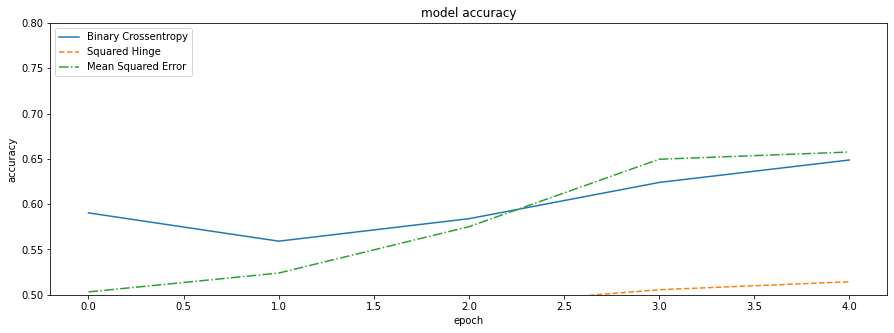

In [ ]:
# PLOT ACCURACIES
styles=['-','--','-.']
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.50,0.8])
plt.show()


In [ ]:
def plot_results(model_history):
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [ ]:
final_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
final_cnn.compile(loss = 'binary_crossentropy', metrics =['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))

final_cnn_history = final_cnn.fit_generator(train_flow,
                   validation_data = val_flow,
                   steps_per_epoch = 100,
                   epochs = 10,
                   validation_steps = 50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
100/100 [==============================] - 122s 1s/step - loss: 0.6923 - acc: 0.5188 - val_loss: 0.6883 - val_acc: 0.5584
Epoch 2/10
100/100 [==============================] - 120s 1s/step - loss: 0.6849 - acc: 0.5628 - val_loss: 0.6858 - val_acc: 0.5200
Epoch 3/10
100/100 [==============================] - 121s 1s/step - loss: 0.6660 - acc: 0.5916 - val_loss: 0.6560 - val_acc: 0.6000
Epoch 4/10
100/100 [==============================] - 121s 1s/step - loss: 0.6494 - acc: 0.6176 - val_loss: 0.6555 - val_acc: 0.5984
Epoch 5/10
100/100 [==============================] - 122s 1s/step - loss: 0.6429 - acc: 0.6192 - val_loss: 0.6448 - val_acc: 0.6256
Epoch 6/10
100/100 [==============================] - 120s 1s/step - loss: 0.6277 - acc: 0.6444 - val_loss: 0.6098 - val_acc: 0.6656
Epoch 7/10
100/100 [==============================] - 121s 1s/step - loss: 0.6053 - acc: 0.6644 - val_loss: 0.6473 - val_acc: 0.6272
Epoch 8/10
100/100 [==============================] - 121s 1s/step - 

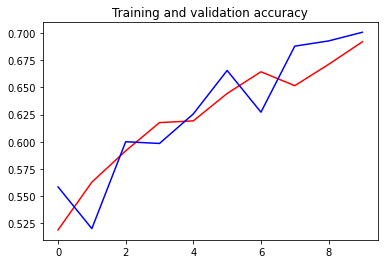

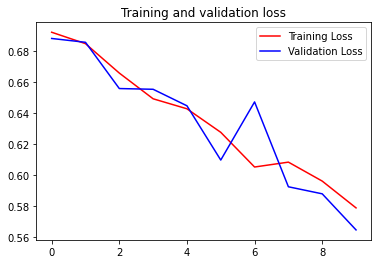

In [ ]:
plot_results(final_cnn_history)

In [ ]:
pre_trainned_model = tf.keras.applications.InceptionV3(include_top = False,
                                                       weights = 'imagenet',
                                                       input_shape = (150,150,3))

for layer in pre_trainned_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
last_layer = pre_trainned_model.get_layer('mixed9_1')

pretrainned_last_output = last_layer.output

x = tf.keras.layers.Flatten()(pretrainned_last_output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

tf_model = tf.keras.models.Model(pre_trainned_model.input , x)


In [ ]:
desired_accuracy = 0.90
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, log={}):
        if (log.get('val_acc')>desired_accuracy):
            print('\nDesired validation accuracy reached, stop training')
            self.model.stop_training = True
callbacks = my_callback

In [ ]:
tf_model.compile(loss='binary_crossentropy', metrics = ['acc'], optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4))
tf_model_history = tf_model.fit_generator(train_flow,
                                           validation_data = val_flow,
                                           steps_per_epoch = 100,
                                           epochs = 10,
                                           validation_steps = 50,
#                                            callbacks = [callbacks]
                                           )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
100/100 [==============================] - 168s 2s/step - loss: 0.5187 - acc: 0.8832 - val_loss: 0.1910 - val_acc: 0.9344
Epoch 2/10
100/100 [==============================] - 159s 2s/step - loss: 0.2270 - acc: 0.9356 - val_loss: 0.1842 - val_acc: 0.9400
Epoch 3/10
100/100 [==============================] - 158s 2s/step - loss: 0.2015 - acc: 0.9360 - val_loss: 0.2122 - val_acc: 0.9392
Epoch 4/10
100/100 [==============================] - 158s 2s/step - loss: 0.1642 - acc: 0.9480 - val_loss: 0.1599 - val_acc: 0.9520
Epoch 5/10
100/100 [==============================] - 158s 2s/step - loss: 0.1453 - acc: 0.9536 - val_loss: 0.1581 - val_acc: 0.9464
Epoch 6/10
100/100 [==============================] - 158s 2s/step - loss: 0.1672 - acc: 0.9484 - val_loss: 0.1950 - val_acc: 0.9440
Epoch 7/10
100/100 [==============================] - 157s 2s/step - loss: 0.1407 - acc: 0.9576 - val_loss: 0.2506 - val_acc: 0.9216
Epoch 8/10
100/100 [==============================] - 158s 2s/step - 